In [175]:
import polars as pl
import numpy as np
from scipy.stats import norm

import requests
import json

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# UC Housing

In [176]:
df_2bdr = pl.read_csv('./data/2bdr.csv')
df_2bdr

Year,Oakland-Fremont,San Francisco,Santa Cruz,Merced,Los Angeles,Davis,Irvine,Riverside,San Diego,Santa Barbara
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
2019,2126,3170,2439,839,1791,1342,2037,1232,2460,1951
2020,2239,3339,2519,947,1956,1404,2216,1289,2570,2324
2021,2383,3553,3021,1067,2058,1511,2331,1390,2630,2374
2022,2274,3198,3138,1120,2044,1684,2324,1509,2710,2516
2023,2405,3188,3293,1243,2222,1851,2539,1751,2940,2667


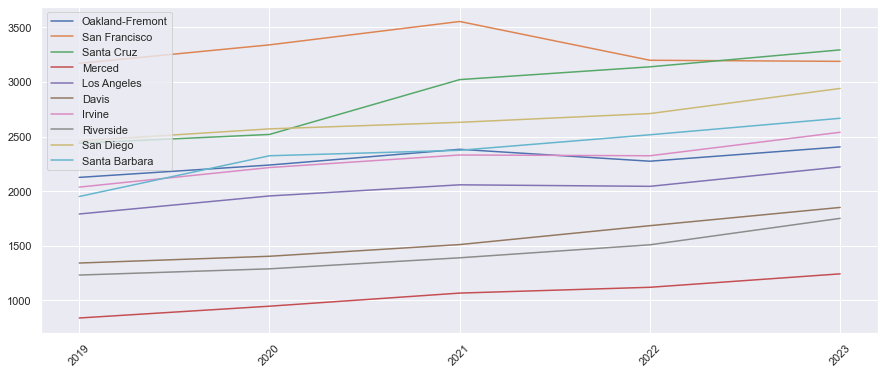

In [177]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 6)

for col in df_2bdr.select(pl.all().exclude('Year')).columns:
    plt.plot(df_2bdr['Year'], df_2bdr[col], label=f'{col}')

ax.legend()
plt.xticks(df_2bdr['Year'], rotation=45)
plt.show()


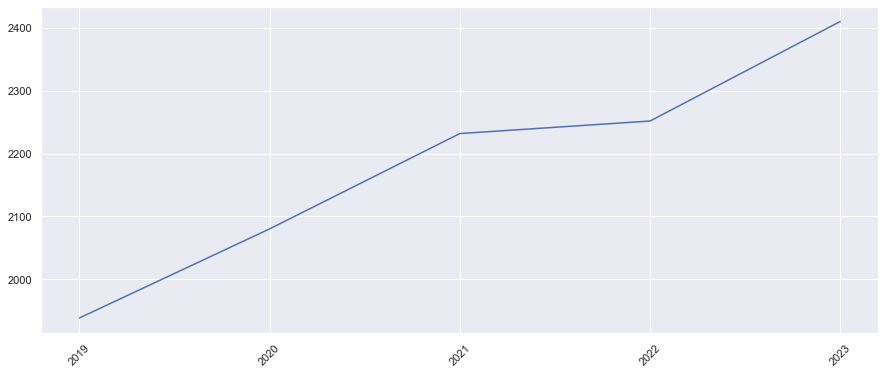

In [178]:
avg_yearly_change = df_2bdr.select([
    pl.col('Year'),
    pl.concat_list(pl.all().exclude('Year')).arr.eval(pl.element().mean()).arr.first().alias('AvgCost'),
])

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 6)
plt.plot(avg_yearly_change['Year'], avg_yearly_change['AvgCost'])
plt.xticks(avg_yearly_change['Year'], rotation=45)
plt.show()

/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_4195/2698104104.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


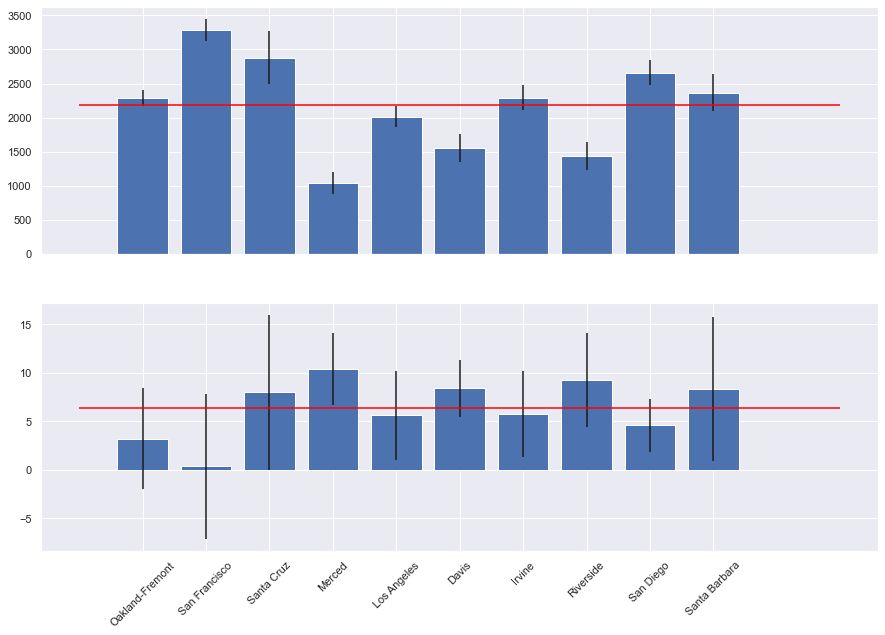

In [6]:
df_avg_cost_change = pl.concat([
    df_2bdr.select(pl.all().exclude('Year').mean().round(2)),
    df_2bdr.select(pl.all().exclude('Year').std().round(2)),
    df_2bdr.select((pl.all().exclude('Year').pct_change() * 100).mean().round(2)),
    df_2bdr.select((pl.all().exclude('Year').pct_change() * 100).std().round(2)),
], rechunk=True)


fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True) # frameon=False removes frames
fig.set_size_inches(15, 10)

ax1.bar(df_avg_cost_change.columns, df_avg_cost_change.row(0), yerr=df_avg_cost_change.row(1))
ax1.hlines(np.mean(df_avg_cost_change.row(0)), -1, 11, colors='red')

ax2.bar(df_avg_cost_change.columns, df_avg_cost_change.row(2), yerr=df_avg_cost_change.row(3))
ax2.hlines(np.mean(df_avg_cost_change.row(2)), -1, 11, colors='red')

plt.xticks(rotation=45)

fig.show()

In [7]:
np.corrcoef(df_avg_cost_change.row(0), df_avg_cost_change.row(2))

array([[ 1.        , -0.74757451],
       [-0.74757451,  1.        ]])

### Should we accept a 7%

Probability of that year's increase in cost of living is greater than 7%

/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_4195/2955248883.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


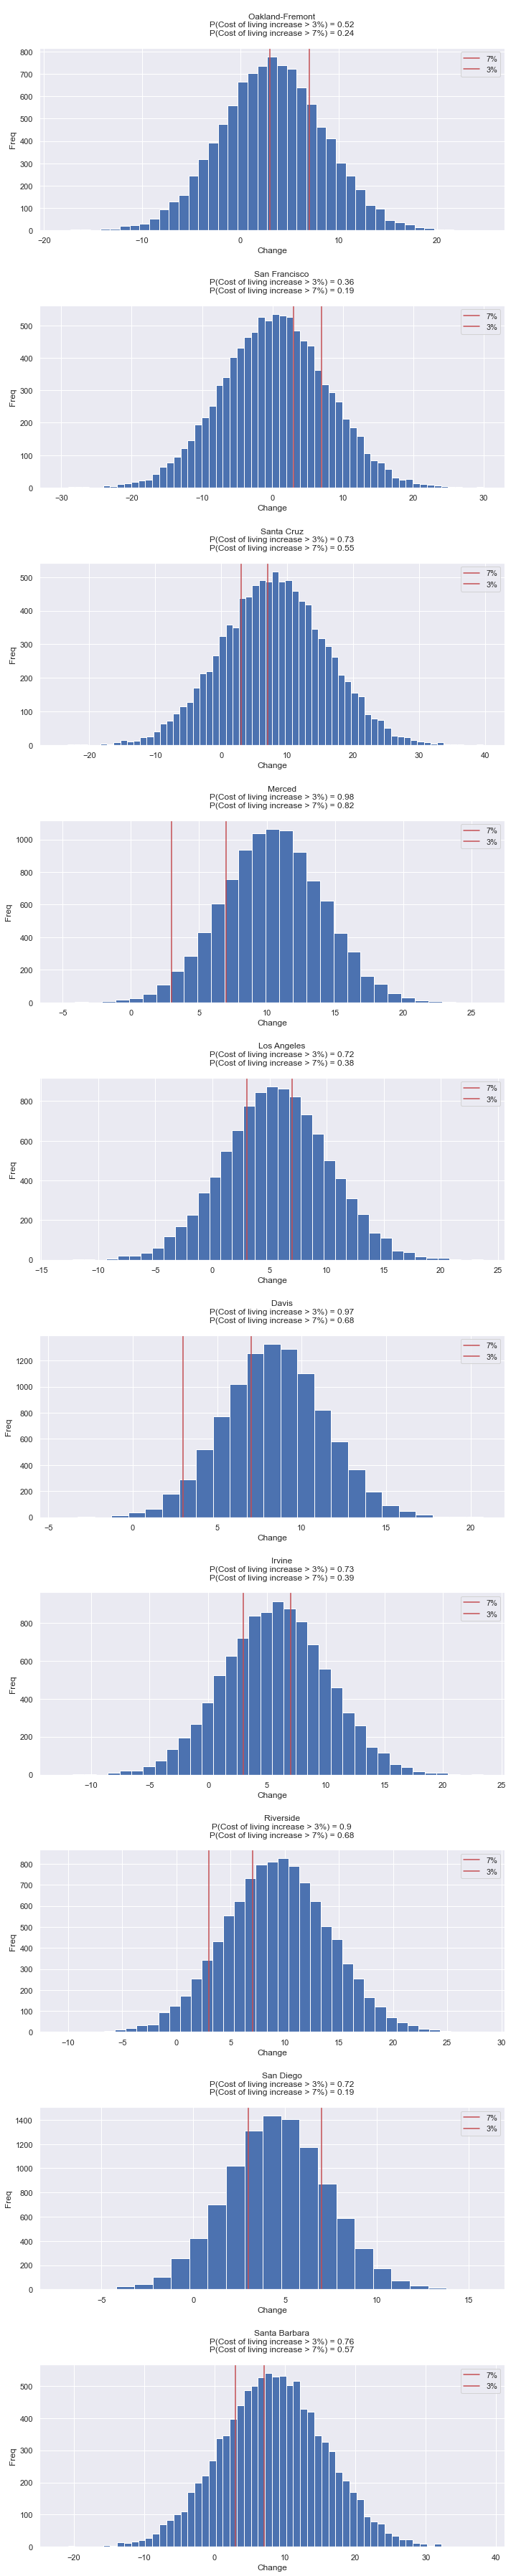

In [174]:
n = len(df_avg_cost_change.columns)

fig, axs = plt.subplots(n, 1, tight_layout=True)
fig.set_size_inches(10, n*5)
axs = axs.flatten()

for i, col in enumerate(df_avg_cost_change.columns):

    loc = df_avg_cost_change[col][2]
    scale = df_avg_cost_change[col][3]

    sample = norm.rvs(
        loc=loc, 
        scale=scale, 
        size=10_000, 
        random_state=42
    )

    axs[i].hist(sample, bins=np.arange(min(sample)-1, max(sample)+1, 1))
    axs[i].axvline(x=7, color='r', label='7%')
    axs[i].axvline(x=3, color='r', label='3%')

    axs[i].set_xlabel('Change')
    axs[i].set_ylabel('Freq')
    axs[i].set_title(f'''
        {col}
        P(Cost of living increase > 3%) = {np.round(norm.sf(3, loc, scale), 2)}
        P(Cost of living increase > 7%) = {np.round(norm.sf(7, loc, scale), 2)}
    ''')

    axs[i].legend()


fig.show()

# Standardized

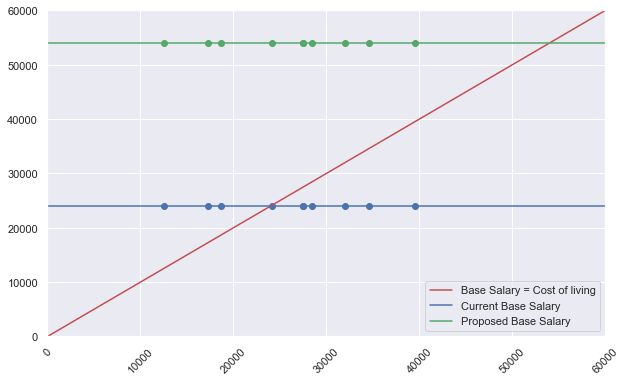

In [164]:
current_base_salary = 24_000
proposed_base_salary = 54_000

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

ax.axline([-1, -1], [1, 1], color='r', label='Base Salary = Cost of living')
ax.axhline(y=current_base_salary, color='b', label='Current Base Salary')
ax.axhline(y=proposed_base_salary, color='g', label='Proposed Base Salary')

compus_name = df_avg_cost_change.columns
x = np.array(df_avg_cost_change.row(0)) * 12
y = [current_base_salary] * len(x)
plt.scatter(x, y, marker='o', color='b')

compus_name = df_avg_cost_change.columns
x = np.array(df_avg_cost_change.row(0)) * 12
y = [proposed_base_salary] * len(x)
plt.scatter(x, y, marker='o', color='g')

ax.set(xlim=(0, 60_000), ylim=(0, 60_000))
ax.legend()
plt.xticks(rotation=45)
plt.show()

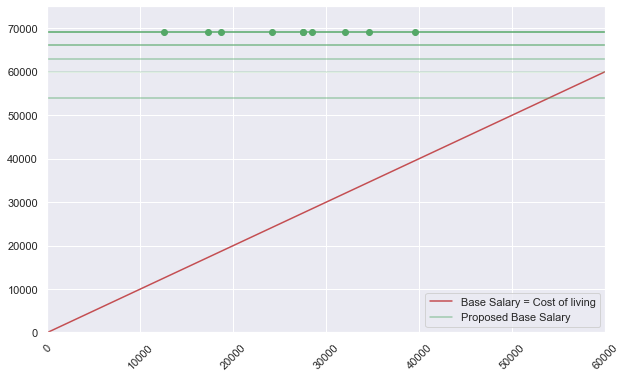

In [165]:
current_base_salary = 24_000
proposed_base_salary = 54_000

yearly_increase = 3000

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

ax.axline([-1, -1], [1, 1], color='r', label='Base Salary = Cost of living')
ax.axhline(y=proposed_base_salary, color='g', label='Proposed Base Salary', alpha=0.5)


n = 5
alphas = np.linspace(0, 1, n)
cum_yearly_increase = yearly_increase

for (i, alpha) in enumerate(alphas):
    proposed_base_salary += yearly_increase
    ax.axhline(y=proposed_base_salary, color='g', alpha=alphas[i])

compus_name = df_avg_cost_change.columns
x = np.array(df_avg_cost_change.row(0)) * 12
y = [proposed_base_salary] * len(x)
plt.scatter(x, y, marker='o', color='g')

ax.set(xlim=(0, 60_000), ylim=(0, 75_000))
ax.legend()
plt.xticks(rotation=45)
plt.show()

# Localized

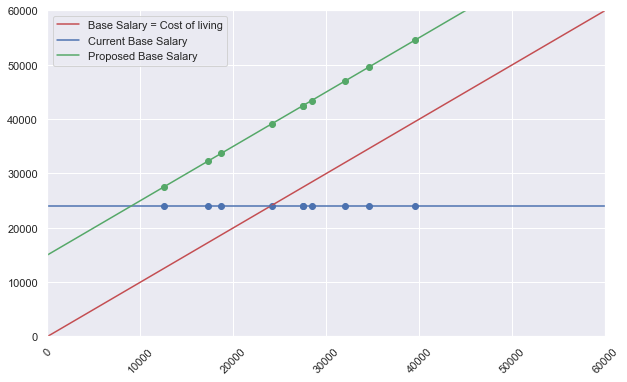

In [166]:
increase = 15_000

monthly_housing_cost = df_avg_cost_change.row(0)
yearly_housing_cost = np.array(monthly_housing_cost) * 12

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

ax.axline([0, 0], [1, 1], color='r', label='Base Salary = Cost of living')
ax.axhline(y=current_base_salary, color='b', label='Current Base Salary')
ax.axline([0, increase], [1, increase+1], color='g', label='Proposed Base Salary')

compus_name = df_avg_cost_change.columns
x = yearly_housing_cost
y = [current_base_salary] * len(x)
plt.scatter(x, y, marker='o', color='b')

compus_name = df_avg_cost_change.columns
x = np.array(df_avg_cost_change.row(0)) * 12
y = x + increase
plt.scatter(x, y, marker='o', color='g')

ax.set(xlim=(0, 60_000), ylim=(0, 60_000))
ax.legend()
plt.xticks(rotation=45)
plt.show()


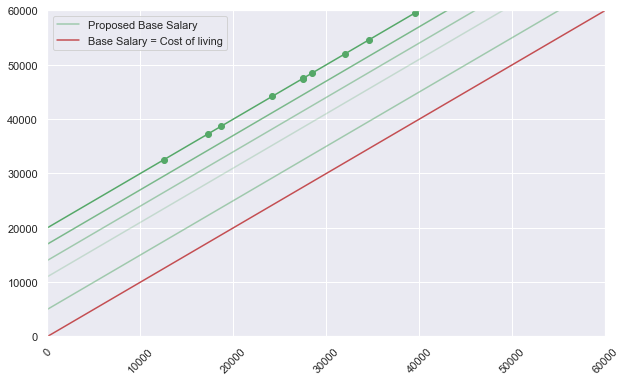

In [167]:
base_increase = 5000
yearly_increase = 3000

monthly_housing_cost = df_avg_cost_change.row(0)
yearly_housing_cost = np.array(monthly_housing_cost) * 12

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

minimum = 0.0001
alpha = 1

ax.axline([0, base_increase], [1, base_increase+1], color='g', label='Proposed Base Salary', alpha=0.5)



n = 5
alphas = np.linspace(0, 1, n)
cum_yearly_increase = yearly_increase

for (i, alpha) in enumerate(alphas):
    base_increase += yearly_increase
    ax.axline([0, base_increase], [1, base_increase+1], color='g', alpha=alphas[i])

ax.axline([0, 1], [1, 2], color='r', label='Base Salary = Cost of living', alpha=alphas[i])
    
compus_name = df_avg_cost_change.columns
x = np.array(df_avg_cost_change.row(0)) * 12
y = x + base_increase
plt.scatter(x, y, marker='o', color='g')


ax.set(xlim=(0, 60_000), ylim=(0, 60_000))
ax.legend()
plt.xticks(rotation=45)
plt.show()


# CPI
U.S. Bureau of Labor Statistics – United States Department of Labor

https://beta.bls.gov/dataQuery

In [9]:
code_book = {
    'All items in U.S. city average, all urban consumers, seasonally adjusted': 'CUSR0000SA0',
    'Shelter in U.S. city average, all urban consumers, seasonally adjusted': 'CUSR0000SAH1',

    'West region, All items': 'CUUR0400SA0',
    'Los Angeles, All items': 'CUURS49ASA0',
    'San Francisco, All items': 'CUURS49BSA0',

    'Los Angeles-Long Beach-Anaheim': 'CUURS49ASA0',
    'Riverside-San Bernardino-Ontario': 'CUURS49CSA0',
    'San Diego-Carlsbad': 'CUURS49ESA0',
    'San Francisco-Oakland-Hayward': 'CUURS49BSA0',
}

In [10]:
headers = {'Content-type': 'application/json'}

series = [
    code_book['All items in U.S. city average, all urban consumers, seasonally adjusted'],
    code_book['Shelter in U.S. city average, all urban consumers, seasonally adjusted'],
]

data = json.dumps({"seriesid": series, "startyear":"2012", "endyear":"2023"})

p = requests.post('https://api.bls.gov/publicAPI/v1/timeseries/data/', data=data, headers=headers)

json_data = json.loads(p.text)

results = json_data['Results']['series']

In [11]:
[all_items, shelter] = results

In [12]:
df_shelter = pl.DataFrame([
    pl.Series('Year', [int(d['year']) for d in shelter['data']], pl.Int16),
    pl.Series('Month', [d['periodName'] for d in shelter['data']], pl.Utf8),
    pl.Series('CpiShelter', [float(d['value']) for d in shelter['data']], pl.Float32),
]).sort('Year')

df_all_items = pl.DataFrame([
    pl.Series('Year', [int(d['year']) for d in all_items['data']], pl.Int16),
    pl.Series('Month', [d['periodName'] for d in all_items['data']], pl.Utf8),
    pl.Series('CpiAll', [float(d['value']) for d in all_items['data']], pl.Float32),
]).sort('Year')

df_monthly_cpi = (
    df_all_items
    .join(
        df_shelter, 
        on=['Year', 'Month'], 
        how='inner'
    )
)

df_monthly_cpi.head()

Year,Month,CpiAll,CpiShelter
i16,str,f32,f32
2012,"""December""",231.220993,259.644012
2012,"""November""",231.248993,259.216003
2012,"""October""",231.638,258.81601
2012,"""September""",231.014999,258.233002
2012,"""August""",229.917999,257.647003


In [13]:
df_yearly_cpi = (
    df_monthly_cpi
    .groupby('Year')
    .agg([
        pl.col('CpiAll').mean().alias('CpiAllMean'),
        pl.col('CpiAll').std().alias('CpiAllStd'),
        pl.col('CpiShelter').mean().alias('CpiShelterMean'),
        pl.col('CpiShelter').std().alias('CpiShelterStd'),
    ])
    .sort('Year')
    .with_columns([
        (pl.col('CpiAllMean') - pl.col('CpiAllMean').shift(1)).alias('DiffMeanCpiAll'),
        (pl.col('CpiShelterMean') - pl.col('CpiShelterMean').shift(1)).alias('DiffMeanCpiShelter'),
    ])
)

df_yearly_cpi

Year,CpiAllMean,CpiAllStd,CpiShelterMean,CpiShelterStd,DiffMeanCpiAll,DiffMeanCpiShelter
i16,f32,f32,f32,f32,f32,f32
2012,229.586075,1.350803,257.080475,1.67952,null,null
2013,232.951736,0.969708,263.050323,1.931199,3.365662,5.969849
2014,236.715012,0.785505,270.509369,2.332262,3.763275,7.459045
2015,237.001755,1.145959,278.802063,2.664488,0.286743,8.292694
2016,240.005432,1.740881,288.233002,3.117234,3.003677,9.430939
2017,245.121017,1.498123,297.808685,2.853534,5.115585,9.575684
2018,251.098923,1.38294,307.661865,2.935363,5.977905,9.85318
2019,255.6465,1.761585,318.047852,3.039066,4.547577,10.385986
2020,258.838257,1.777962,325.89566,1.536052,3.191757,7.847809


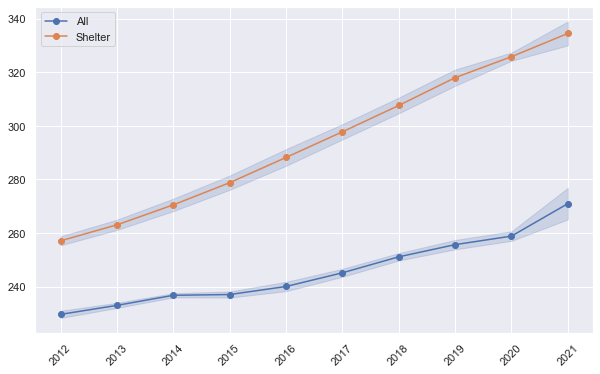

In [14]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

x = df_yearly_cpi['Year']
y_all = df_yearly_cpi['CpiAllMean']
std_all = df_yearly_cpi['CpiAllStd']
y_shelter = df_yearly_cpi['CpiShelterMean']
std_shelter = df_yearly_cpi['CpiShelterStd']

ax.plot(x, y_all, 'o', label='All', linestyle='-')
plt.fill_between(x, y_all - std_all, y_all + std_all, color='b', alpha=0.2)
ax.plot(x, y_shelter, 'o', label='Shelter', linestyle='-')
plt.fill_between(x, y_shelter - std_shelter, y_shelter + std_shelter, color='b', alpha=0.2)

ax.legend()
plt.xticks(x, rotation=45)
plt.show()

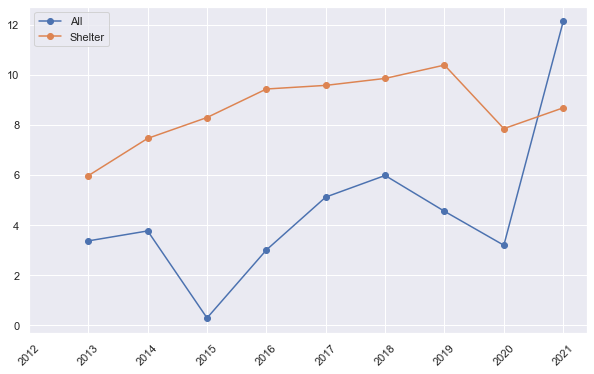

In [28]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

x = df_yearly_cpi['Year']
y_all = df_yearly_cpi['DiffMeanCpiAll']
y_shelter = df_yearly_cpi['DiffMeanCpiShelter']

ax.plot(x, y_all, 'o', label='All', linestyle='-')
ax.plot(x, y_shelter, 'o', label='Shelter', linestyle='-')

ax.legend()
plt.xticks(x, rotation=45)
plt.show()

# AdvisorySmith COLI

https://advisorsmith.com/data/coli/

In [20]:
campuses = ['Berkley', 'Davis', 'Irvine', 'Los Angeles', 'Merced', 'Riverside', 'San Diego', 'Santa Barbara', 'Santa Cruz']

df = pl.read_csv('./data/advisorsmith_coli.csv').filter(pl.col('State') == 'CA').filter(pl.col('City').is_in(campuses))
df

City,State,Cost of Living Index
str,str,f64
"""Merced""","""CA""",108.2
"""Riverside""","""CA""",116.1
"""San Diego""","""CA""",136.2
"""Santa Cruz""","""CA""",163.9
"""Los Angeles""","""CA""",140.6
